# What attribute of wine affect red wine quality and how?

## Introduction

Red wine has specific attributes (acidity, sugar, alcohol, etc.) that determine its taste and perceived quality. The quality of red wine is often evaluated by professional sommeliers through a time-consuming and subjective assessment process. Attributes of red wine and its quality rating have been determined and collected into a data set that is donated to the UCI machine learning repository. The data set includes 12 variables in each respective column, with each row documenting a wine's attribute measurements and quality.

The following are the potential predictor variables including their units:


<h4 style="text-align: center;"> Table 1: List of variables and their units </h4>

|Variable|Units|
|--|--|
|Fixed acidity|g<sub>(tartaric acid)</sub>/dm<sup>3</sup>|
|Volatile acidity|g<sub>(acetic acid)</sub>/dm<sup>3</sup>|
|Citric acid|g/dm<sup>3</sup>|
|Residual sugar|g/dm<sup>3</sup>|
|Chlorides|g<sub>(sodium chloride)</sub>/dm<sup>3</sup>|
|Free sulfur dioxide|mg/dm<sup>3</sup>
|Total sulfur dioxide|mg/dm<sup>3</sup>|
|Density|g/cm<sup>3</sup>
|pH|0-14 pH scale|
|Sulphates|g<sub>(potassium sulphate)</sub>/dm<sup>3</sup>|
|Alcohol|vol. %|
|Quality|0-10 scale|

</br> </br>

This project will take that data and attempt to answer the question:
*What attributes of red wine affect the quality and how?*

For relevant documentation and details of the data set, reference documentation [(1)](#ref_1).


## Methods

Methods will include the [*Preliminary exploratory data analysis*](#pre_data_analysis) and the [*Data analysis*](#data_analysis) section

First, we will read the data set from the web link and wrangle the data into a tidy format. The data is then split into training and testing data subsets with 0.7 proportion (a seed is set here at 8888 for consistency throughout the analyses). The training data will be used to train a classification model and the testing data will be used to evaluate its accuracy.

Next, we will find statistics of the training data subset, which includes the distribution and the range of the red wine quality, distribution predictor variables, correlation of predictor variables with quality, etc. This will provide insight to our data set and how we will further our data analysis.

# \<do we need to specify functions used in the paragraph here if we have annotations>

In this particular dataset, we have a total of 11 potential predictor variables. From what is observed from the preliminary analysis so far, some predictors may not appear relevant to the perceived wine quality, so appropriate predictor variables should be selectively filtered. We have come to conclude that correlation is best in determining the relevance of predictor variables to class variable. First, we will determine the respective correlations coefficients along with a visualization. A high correlation magnitude suggests higher relevance, so we will find which predictors have the strongest correlations. However, we will find that the correlations are fairly weak for all predictors. Therefore, we will choose the predictors with high correlations relative to all predictors.

**Although we are using correlation to choose which predictors to use, we need to be aware that correlation does not imply causation - confounding variables or third variables may be affecting the results.**


After selecting the appropriate predictors, we will continue with the further data analysis process. We decided to use the K-NN (K nearest neighbour) classification model. We will perform cross-validation with the classification model to determine the most accurate K value whilst maintaining appropriate fit.

# \<can/should do regression?>

Since we are trying to predict red wine quality, a qualitative/categorical variable (0, 1, 2, 3, ..., 9, 10), we will not be using the knn-regression/linear regression model in this case. 

Although quality is determined through numbers, we will not consider them as quantitative variables.

### Preliminary exploratory data analysis
<a id='pre_data_analysis'></a>
##### The preliminary exploratory data analysis will include:
- Reading dataset from web link
- Cleaning and wrangling data into a tidy format
- Splitting into training data and test data
- Summary statistics of training subset
- Visualization of training data predictors and determining appropriate predictors

In [13]:
# load necessary libraries
library(tidyverse)
library(tidymodels)
library(GGally)
library(RColorBrewer)

# initialize custom color palette
COLOR_PALETTE <- c("#F8766D", "#CD9600", "#00BE67", "#00A9FF", "#8A7AFF", "#FF33FC")

#### Reading from web link
Read from link with appropriate delimiter.

In [14]:
# read data frame from UCI machine learning database
red_wine_link <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# use ';' delimiter, read_csv2 will not work as '.' is used as decimal points
red_wine_data <- read_delim(red_wine_link, ';')

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Cleaning and Wrangling
After the data is read, the variable names are renamed to appropriate names.

Additionally, the quality variable is converted to a factor type, as it is a discrete variable.

In [15]:
# rename column names for easier reference
colnames(red_wine_data) <- c("fixed_acidity", "volatile_acidity", "citric_acid", 
                             "residual_sugar", "chlorides", "free_so2", "total_so2",
                             "density", "ph", "sulphates", "alcohol", "quality")

# convert quality to factor type
red_wine_data <- mutate(red_wine_data, quality = as_factor(quality))

# preview wine data and see dimensions of df
print("Table 2: Preview of data set")
head(red_wine_data)
paste("Dimensions of data frame:", dim(red_wine_data))

[1] "Table 2: Preview of data set"


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_so2,total_so2,density,ph,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


[1] "Dimensions of data frame: 1599" "Dimensions of data frame: 12"

#### Splitting
Splitting the data involves some form of randomness. Thus, a seed is set for consistency.

The data is split with `SPLIT_PROPORTION` and strata `quality`.

In [16]:
# set seed for consistency
set.seed(8888)

# splitting data set into training and testing subsets
SPLIT_PROPORTION = 0.7
red_split_data <- initial_split(red_wine_data, prop = SPLIT_PROPORTION, strata = quality)

# assigning variables for respective training and testing data
red_training_data <- training(red_split_data)
red_testing_data <- testing(red_split_data)

# count the number of observations in each subset
paste("Number of observations in training data subset: ", pull(count(red_training_data)))
paste("Number of observations in testing data subset: ", pull(count(red_testing_data)))

[1] "Number of observations in training data subset:  1118"

[1] "Number of observations in testing data subset:  481"

#### Summary statistics of training data subset
Finding the number of `null` and `N/A` values, min, mean, max, and standard deviation.

<sub>Note: rules of tidy data do not apply to visual representation of statistics.</sub>

In [17]:
# check for null/na data
paste("Number of null values: ", sum(map_df(red_training_data, is.null)))
paste("Number of N/A values: ", sum(map_df(red_training_data, is.na)))
paste('')

# code to produce summary statistics of the training data, not used as it is difficult to read
# summary(red_training_data)

# creating an abstract function for the sake of reducing repetitive code, acts as a "code template"
red_map <- function(fn) {
    red_training_data |>
    # remove quality, as it was decided to be the class variable and is now categorical
    select(-quality) |>
    # apply function from parameter into map function
    map_df(fn) |>
    # pivot for better view
    pivot_longer(cols = fixed_acidity:alcohol, values_to = as.character(substitute(fn)), names_to = "variable")
}

# example of what the function does when red_map(mean) is called
# red_training_mean <- red_training_data |>
#     select(-quality) |>
#     map_df(mean) |>
#     pivot_longer(cols = fixed_acidity:alcohol, values_to = "mean", names_to = "variable")

# bind all statistics together, but remove the variable column from all but first
print("Table 3: Summary of data statistics")
bind_cols(red_map(min), select(red_map(mean), mean), select(red_map(max), max), select(red_map(sd), sd))

[1] "Number of null values:  0"

[1] "Number of N/A values:  0"

[1] ""

[1] "Table 3: Summary of data statistics"


variable,min,mean,max,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
fixed_acidity,4.60000,8.3238819,15.90000,1.762946065
volatile_acidity,0.12000,0.5257200,1.58000,0.179151475
citric_acid,0.00000,0.2719320,1.00000,0.195119564
residual_sugar,0.90000,2.5188283,15.50000,1.401099825
chlorides,0.01200,0.0877585,0.61100,0.049444296
free_so2,1.00000,16.0474061,68.00000,10.608373556
total_so2,6.00000,46.3524150,289.00000,33.178320311
density,0.99007,0.9967221,1.00369,0.001908595
ph,2.74000,3.3120125,4.01000,0.155939328


As seen above, there do not appear to be any invalid values of any variable in all the observations, so further wrangling to data in this stage is not necessary.
For some more familiar predictor variables, the values seem reasonable; it is commonly known for red wine to be acidic and have an alcohol content of approximately 10%.

#### Visualization of training data subset and determining appropriate predictors

The last part involves plots that are relevant to the objective.
The first plot is a distribution of the `quality` class variable.

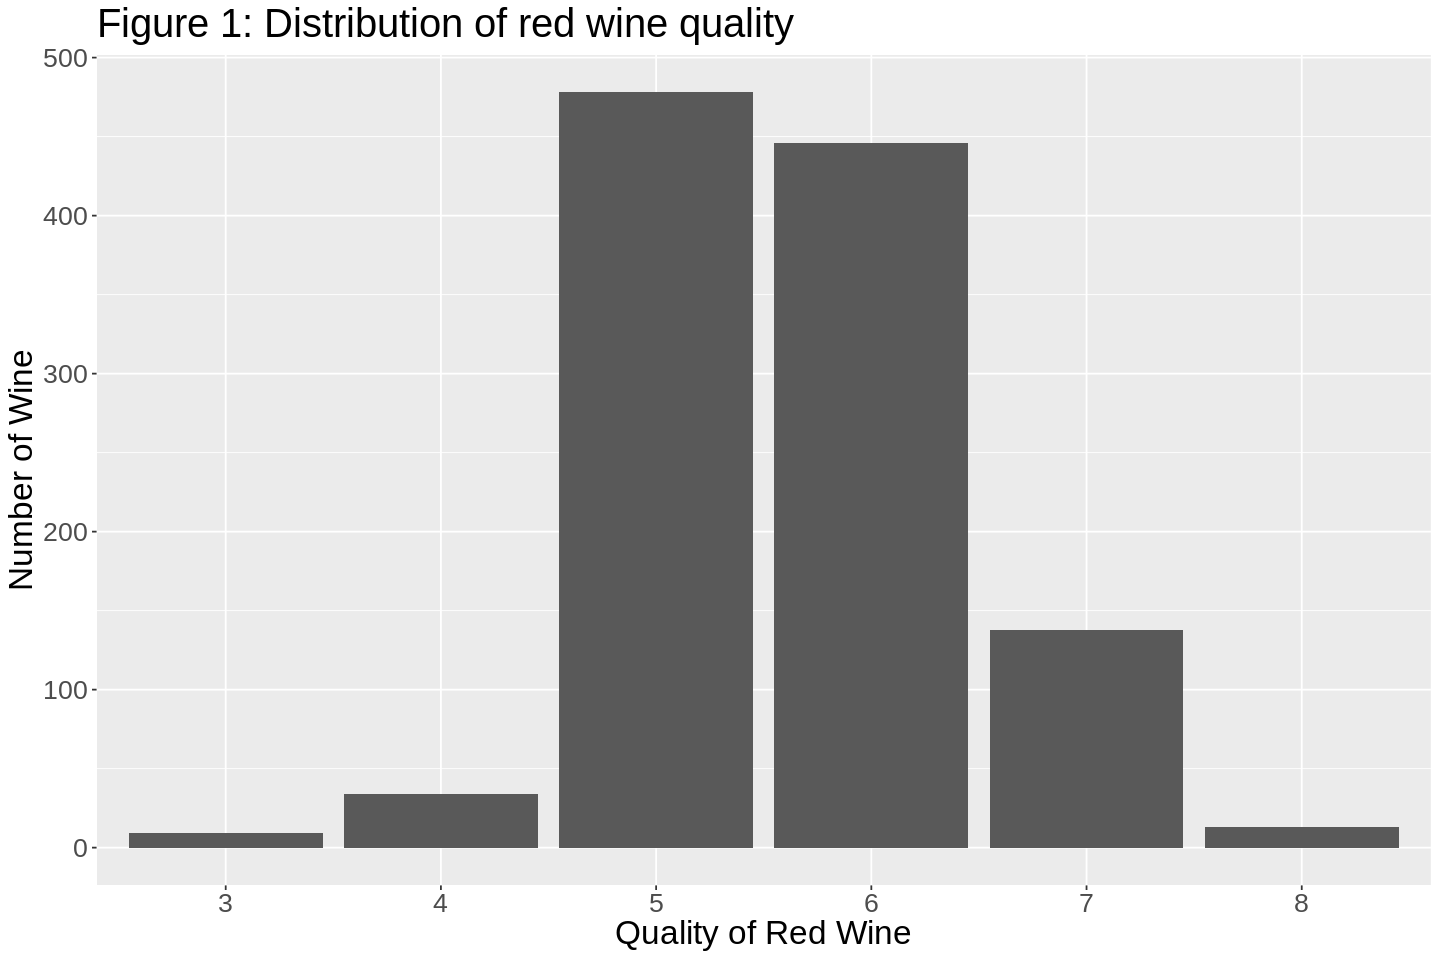

In [18]:
options(repr.plot.width = 12, repr.plot.height = 8)

#plotting the distribution of red wine quality
red_quality_bar <- ggplot(red_training_data, aes(x = quality)) +
    geom_bar() +
    labs(x = "Quality of Red Wine", y = "Number of Wine") + 
    ggtitle("Figure 1: Distribution of red wine quality") +
    theme(text = element_text(size = 20))

red_quality_bar

From the plot above, it can be seen that the `quality` variable is somewhat normally distributed with the center ~5. However, it is notable that the actual range of the testing data is from 3 to 8, despite the documentation noting it is on a scale of  0 to 10. This means that the possible results produced by models trained with this training data will have the `quality` variable range from 3 to 8.

The second plot is comparing the distribution of the potential predictor variables. The data is normalized with `scale()` and plotted as histograms with `facet_wrap()` for appropriate visual comparison. Outliers are removed to improve the visualization.

Warning message:
“Removed 129 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 22 rows containing missing values (geom_bar).”


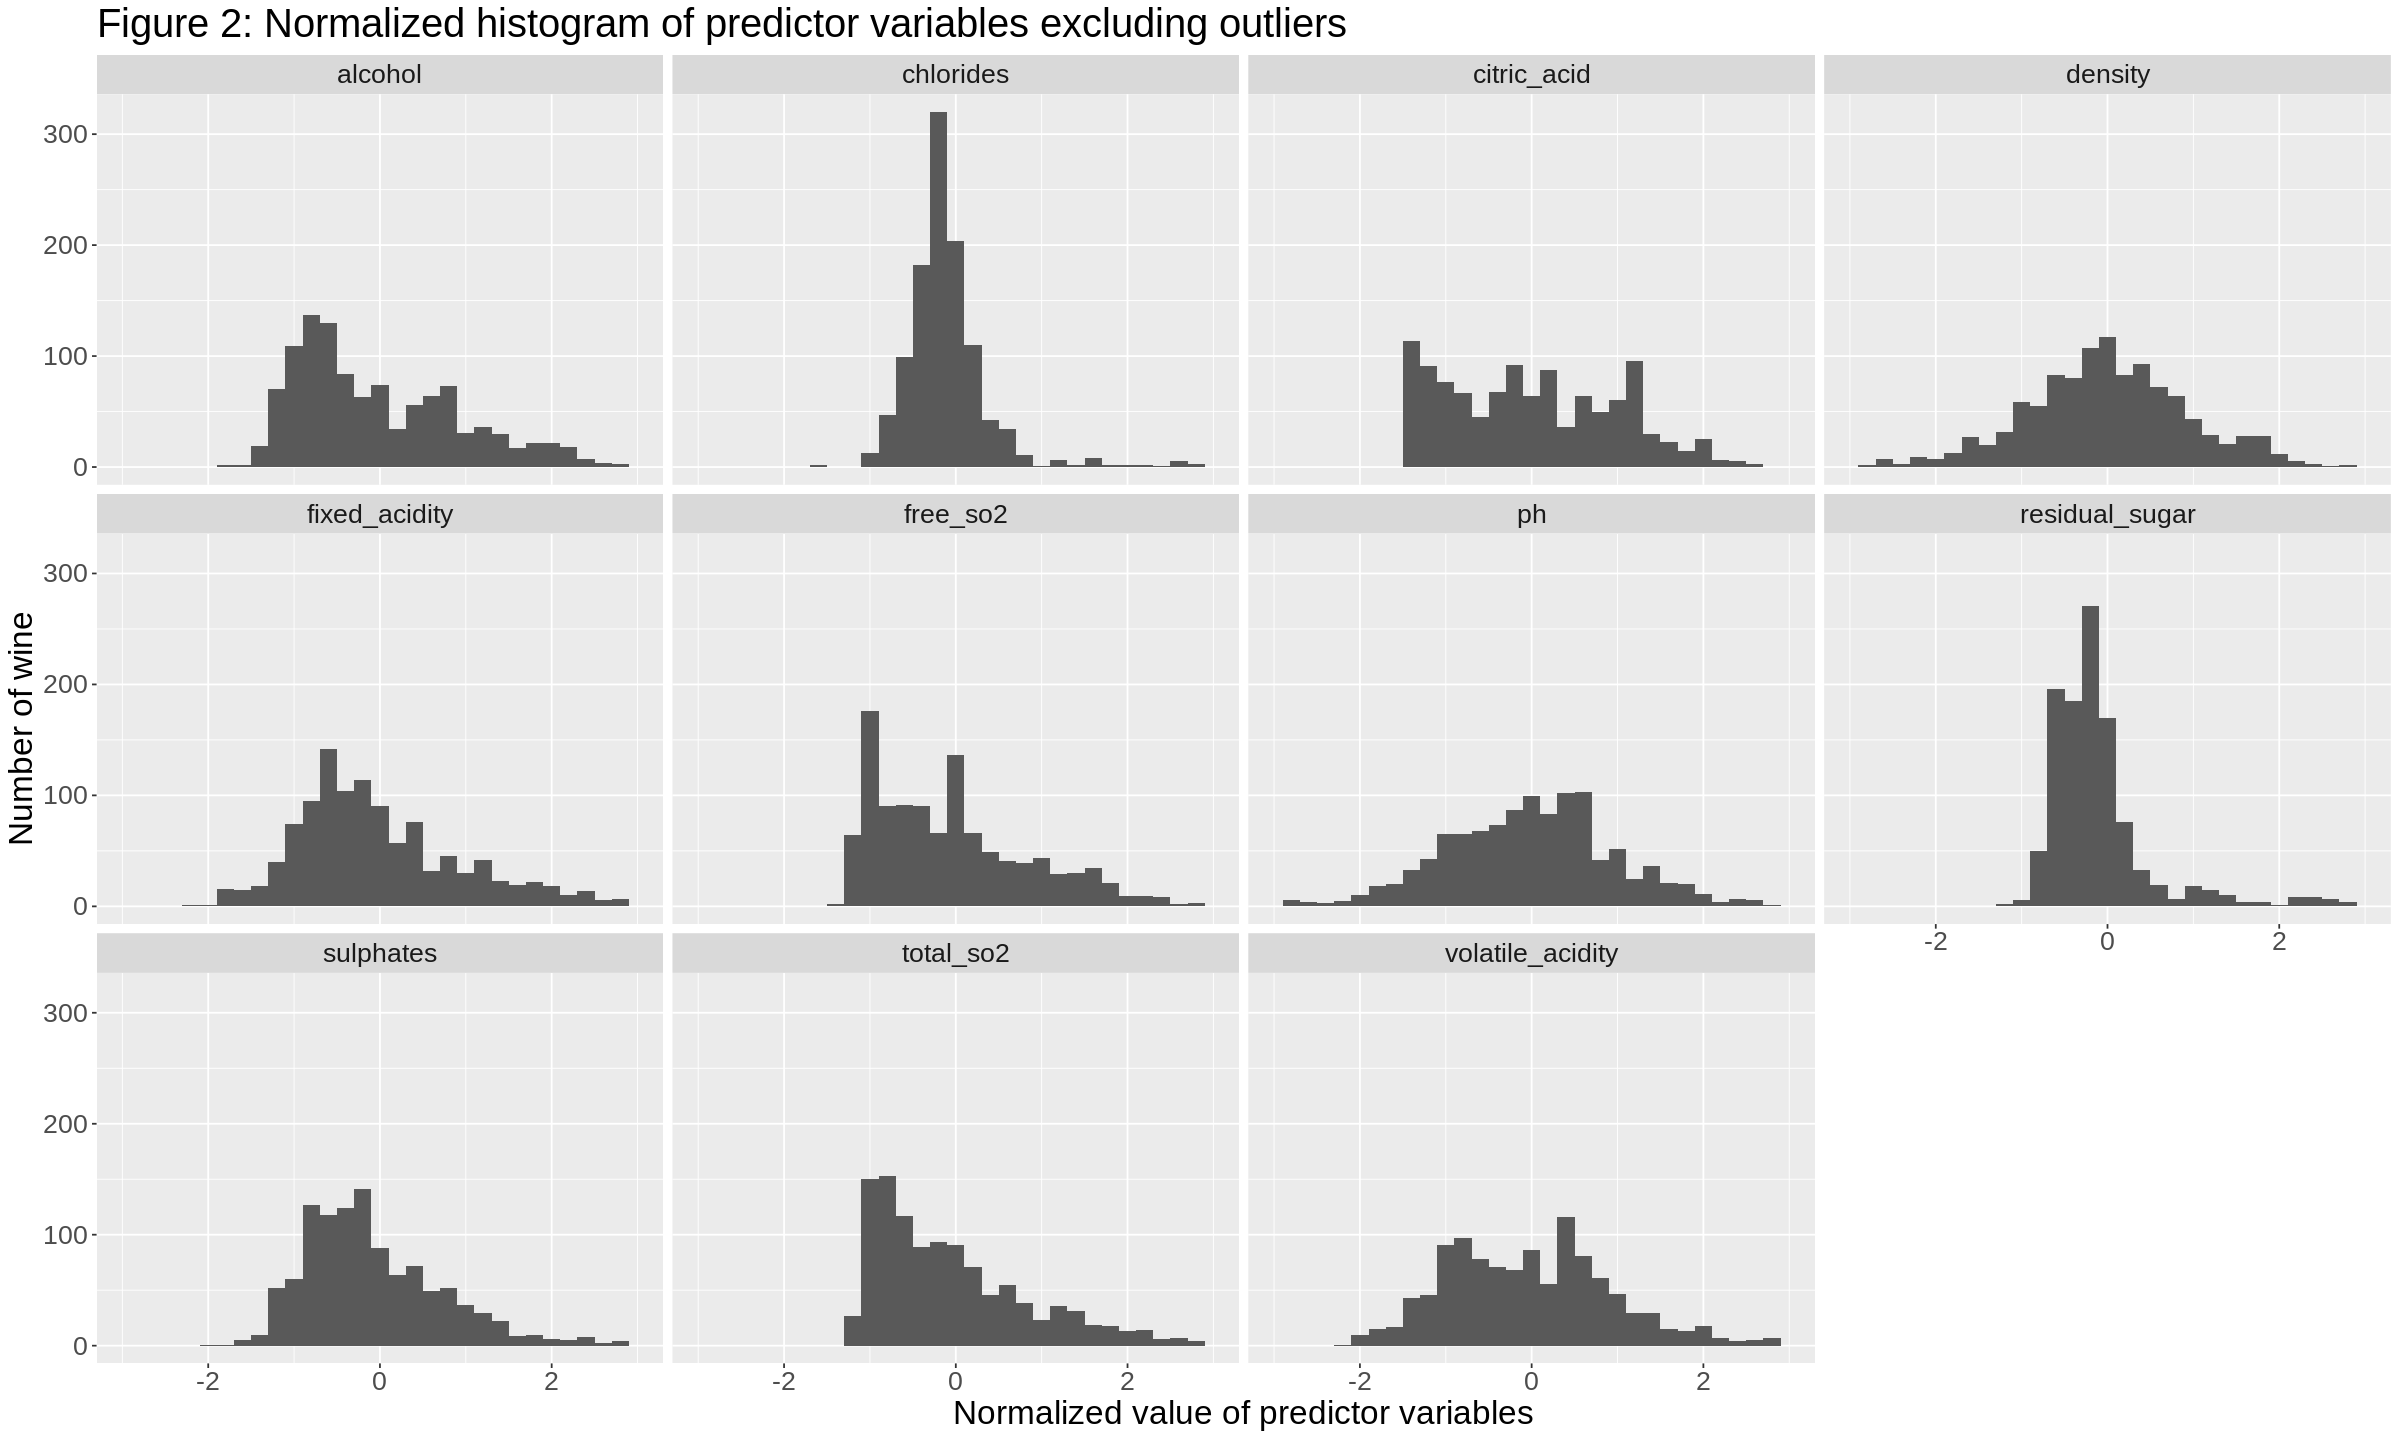

In [19]:
options(repr.plot.width = 20, repr.plot.height = 12)

# normalize the data with respect to each predictor variable
red_training_normalized <- red_training_data |>
    select(-quality) |>
    scale() |>
    as.data.frame()

# pivot data frame so that it is possible to plot histograms with
red_training_normalized_longer <- pivot_longer(red_training_normalized, cols = fixed_acidity:alcohol, names_to = "variable", values_to = "value")

# define binwidth constant
PREDICTOR_BINWIDTH <- 0.2

# plot histograms using facet_wrap. Also limit the horizontal axis to being within 3 standard deviations; beyond 3 SD are considered outliers and result in ideal visualization
red_predictor_histogram <- ggplot(red_training_normalized_longer, aes(x = value)) + 
    geom_histogram(binwidth = PREDICTOR_BINWIDTH) +
    facet_wrap(vars(variable)) +
    ggtitle("Figure 2: Normalized histogram of predictor variables excluding outliers") +
    labs(x = "Normalized value of predictor variables", y = "Number of wine") + 
    theme(text = element_text(size = 20)) +
    xlim(-3,3)

red_predictor_histogram

From the second plot, it can be seen that some of the predictor variable distributions tend to be positively skewed and some distributions have smaller ranges than others.

The third plot will involve `ggpairs()` from the `GGally` extension of `ggplot2`, which creates a scatter plot matrix with correlation coefficients that creates visualizations of relationships between predictor variables.

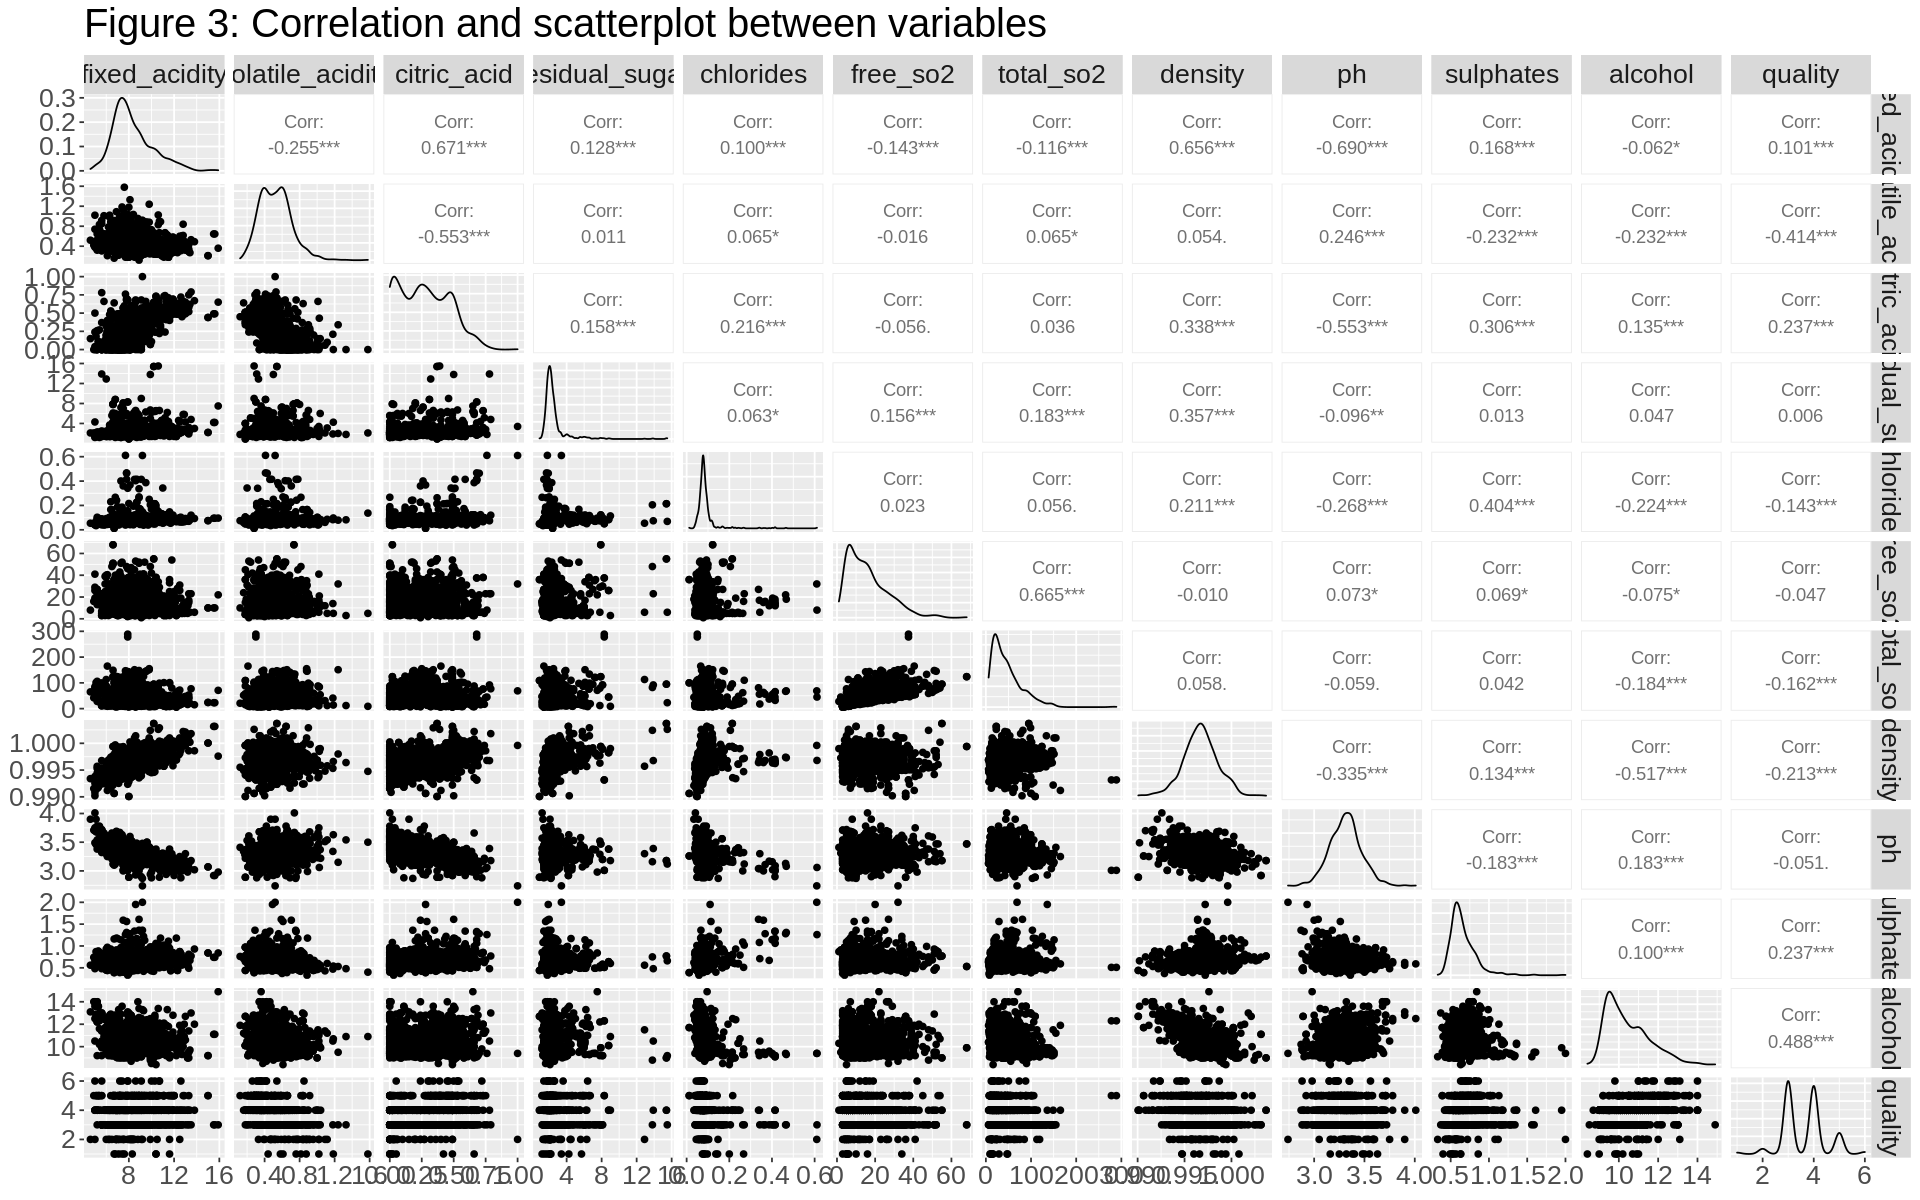

In [20]:
options(repr.plot.width = 16, repr.plot.height = 10)
#  quality is converted back to double type for calculations with correlation coefficient, as quality may also be treated as numeric
red_training_data_quality_as_double <- mutate(red_training_data, quality = as.double(quality))

ggpairs(red_training_data_quality_as_double) + 
    ggtitle("Figure 3: Correlation and scatterplot between variables") +
    theme(text = element_text(size = 20))

From the `ggpairs()` visualization above, a notable observation to be made is that the correlation coefficients are all fairly low relative to the conventional "strong correlation" range of 0.8 - 1.0. As all the predictors would otherwise be considered weakly correlated with `quality`, the correlation coefficients' magnitudes between `quality` and predictor variables will be compared relatively in the training data set to determine which predictors are more strongly correlated with `quality` and thus more appropriate.

In [21]:
# calculate the correlation coefficients seen in the quality column of the ggpairs() visualization
cor_coef <- red_training_data_quality_as_double |>
    # use cor() to calculate coefficient of data frame, produces matrix
    cor() |>
    # convert to tibble (as_data_frame() is deprecated)
    as_tibble() |>
    # select coefficients with quality
    select(quality) |>
    # add correlating predictor names
    bind_cols(predictor_name = colnames(red_training_data)) |>
    # remove last row, as it's quality - quality correlation (it's equal to 1.0)
    head(-1)
cor_coef

cor_summ <- cor_coef |>
    # select column with correlation coefficients
    select(quality) |>
    # get magnitude of coefficients
    abs() |>
    # find median, sd, and the value at one sd higher than median
    # median is used as its less prone to outlier effects
    summarize(median = median(quality), sd = sd(quality)) |>
    mutate(one_sd = median + sd)
cor_summ

quality,predictor_name
<dbl>,<chr>
0.101432357,fixed_acidity
-0.413846117,volatile_acidity
0.236994316,citric_acid
0.005985591,residual_sugar
-0.143013768,chlorides
-0.047283553,free_so2
-0.162116419,total_so2
-0.213139483,density
-0.051134514,ph


median,sd,one_sd
<dbl>,<dbl>,<dbl>
0.1621164,0.1510338,0.3131502


From above, it can be seen that in terms of magnitude, six predictor variables are equal to or higher than the median: `volatile_acidity`, `citric_acid`, `total_so2`, `density`, `sulphates`, and `alcohol`. Being higher than the median may be considered relatively stronger in correlation and the variable can be taken into consideration in further data analysis. 

However, two predictor variables can be observed to have correlation coefficient magnitudes larger than the value of one standard deviation higher than the median (about 84th percentile): `volatile_acidity` and `alcohol`. Therefore, `quality` can be considered to have strong correlations with these two predictors.

Therefore, `volatile_acidity` and `alcohol` are the two predictors that are most appropriate and will be used in further data analyses.

### Data analysis
<a id='data_analysis'></a>
##### Data analysis will include:
- Initial visualization of the selected appropriate predictors with the class variable
- Training classification model using K-NN algorithm
- Training regression model using K-NN algorithm



#### Visualization of appropriate predictors and class variable

Below is a scatter plot, with the selected two predictors, volatile acidity and alcohol (had the strongest correlation with quality), on the axis and the class variable as the color.

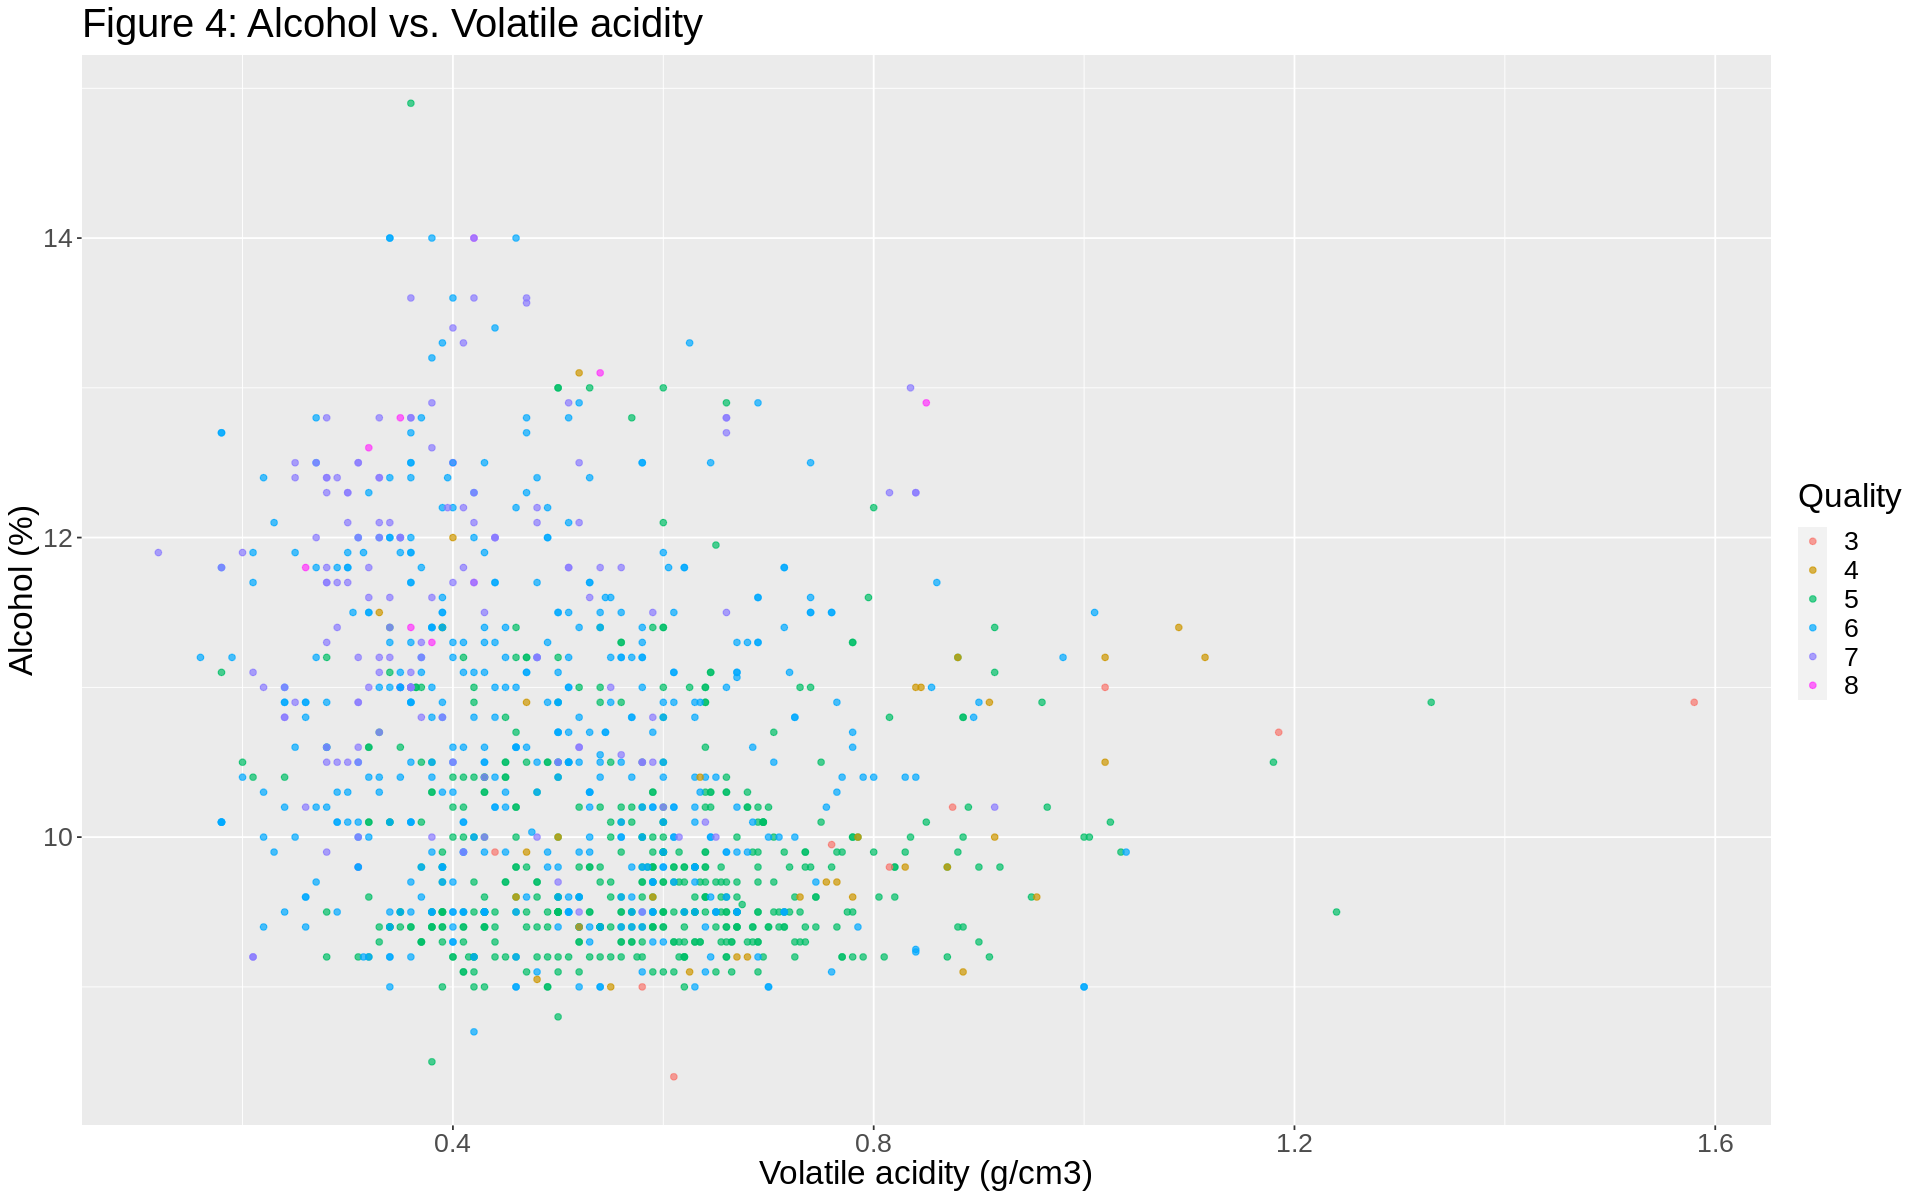

In [22]:
options(repr.plot.width = 16, repr.plot.height = 10)

red_scatter <- ggplot(red_training_data, aes(x = volatile_acidity, y = alcohol, color = quality)) + 
    geom_point(alpha = 0.7) +
    ggtitle("Figure 4: Alcohol vs. Volatile acidity") +
    labs(x = "Volatile acidity (g/cm3)", y = "Alcohol (%)", color = "Quality") + 
    theme(text = element_text(size = 20)) +
    # use customized palette
    scale_color_manual(values = COLOR_PALETTE)

red_scatter

This visualization depicts a scatterplot of the quality ratings of red wine based on the two predictors we selected - `volatile acidity` on the x-axis and `alcohol` on the y-axis. 



#### Training classification model with K-NN
Next, we will construct a training classification model with K-NN to determine the best value of k (code blocks are split so that individual code blocks can be run and skip run time).

In [25]:
# create recipe
recipe <- recipe(quality ~ volatile_acidity + alcohol , data = red_training_data) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

In [ ]:
# model spec with tuning k
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# create cross validation with 5 folds
vfold <- vfold_cv(red_training_data, v = 5, strata = quality)

LOWER_K <- 40
UPPER_K <- 70
BY <- 1

# for values of k to test
# initially start with from = LOWER_K, to = UPPER_K, by = BY
grid_val <- tibble(neighbors = seq(from = LOWER_K, to = UPPER_K, by = BY))

# tune k
knn_results <- workflow() |>
      add_recipe(recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = vfold, grid = grid_val) |>
      collect_metrics()
head(knn_results)

# pull k with greatest accuracy
k <- knn_results |> 
      filter(.metric == "accuracy") |>
      filter(mean == max(mean)) |>
      pull(neighbors)
paste("Highest accuracy when k =", k)

options(repr.plot.width = 8, repr.plot.height = 8)

# plot accuracies 
k_value_plot <- ggplot(filter(knn_results, .metric == "accuracy"), aes(x = neighbors, y = mean)) + 
    geom_line() +
    ggtitle("Cross validation accuracies on training data") +
    labs(x = "K value", y = "Mean accuracy") + 
    theme(text = element_text(size = 18))
k_value_plot

In [26]:
# override value of k for testing/skip processing
k <- 48

# create model spec with tuned k
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
    set_engine("kknn") |>
    set_mode("classification")

# create fit with tuned model spec
fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec_tuned) |>
    fit(data = red_training_data)

# test classification model with testing data
test_predictions <- predict(fit, red_testing_data) |>
    bind_cols(red_testing_data)

# extract accuracy of predictions on testing data
prediction_accuracy <- test_predictions |>
    metrics(truth = quality, estimate = .pred_class)
prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5509356
kap,multiclass,0.2569250


In [27]:
# create grid of volatile_acidity/alcohol values and arrange to data frame
# this is to be used as background color points for visualizing the classification model from training data
va_grid <- seq(min(red_training_data$volatile_acidity),
              max(red_training_data$volatile_acidity),
              length.out = 100)
al_grid <- seq(min(red_training_data$alcohol),
              max(red_training_data$alcohol),
              length.out = 100)
df_grid <- as_tibble(expand.grid(volatile_acidity = va_grid, alcohol = al_grid))

pred_table <- predict(fit, df_grid) |>
    bind_cols(df_grid) |>
    rename(quality = .pred_class)

# classification model with training data
train_predictions <- predict(fit, red_training_data) |>
    bind_cols(red_training_data)

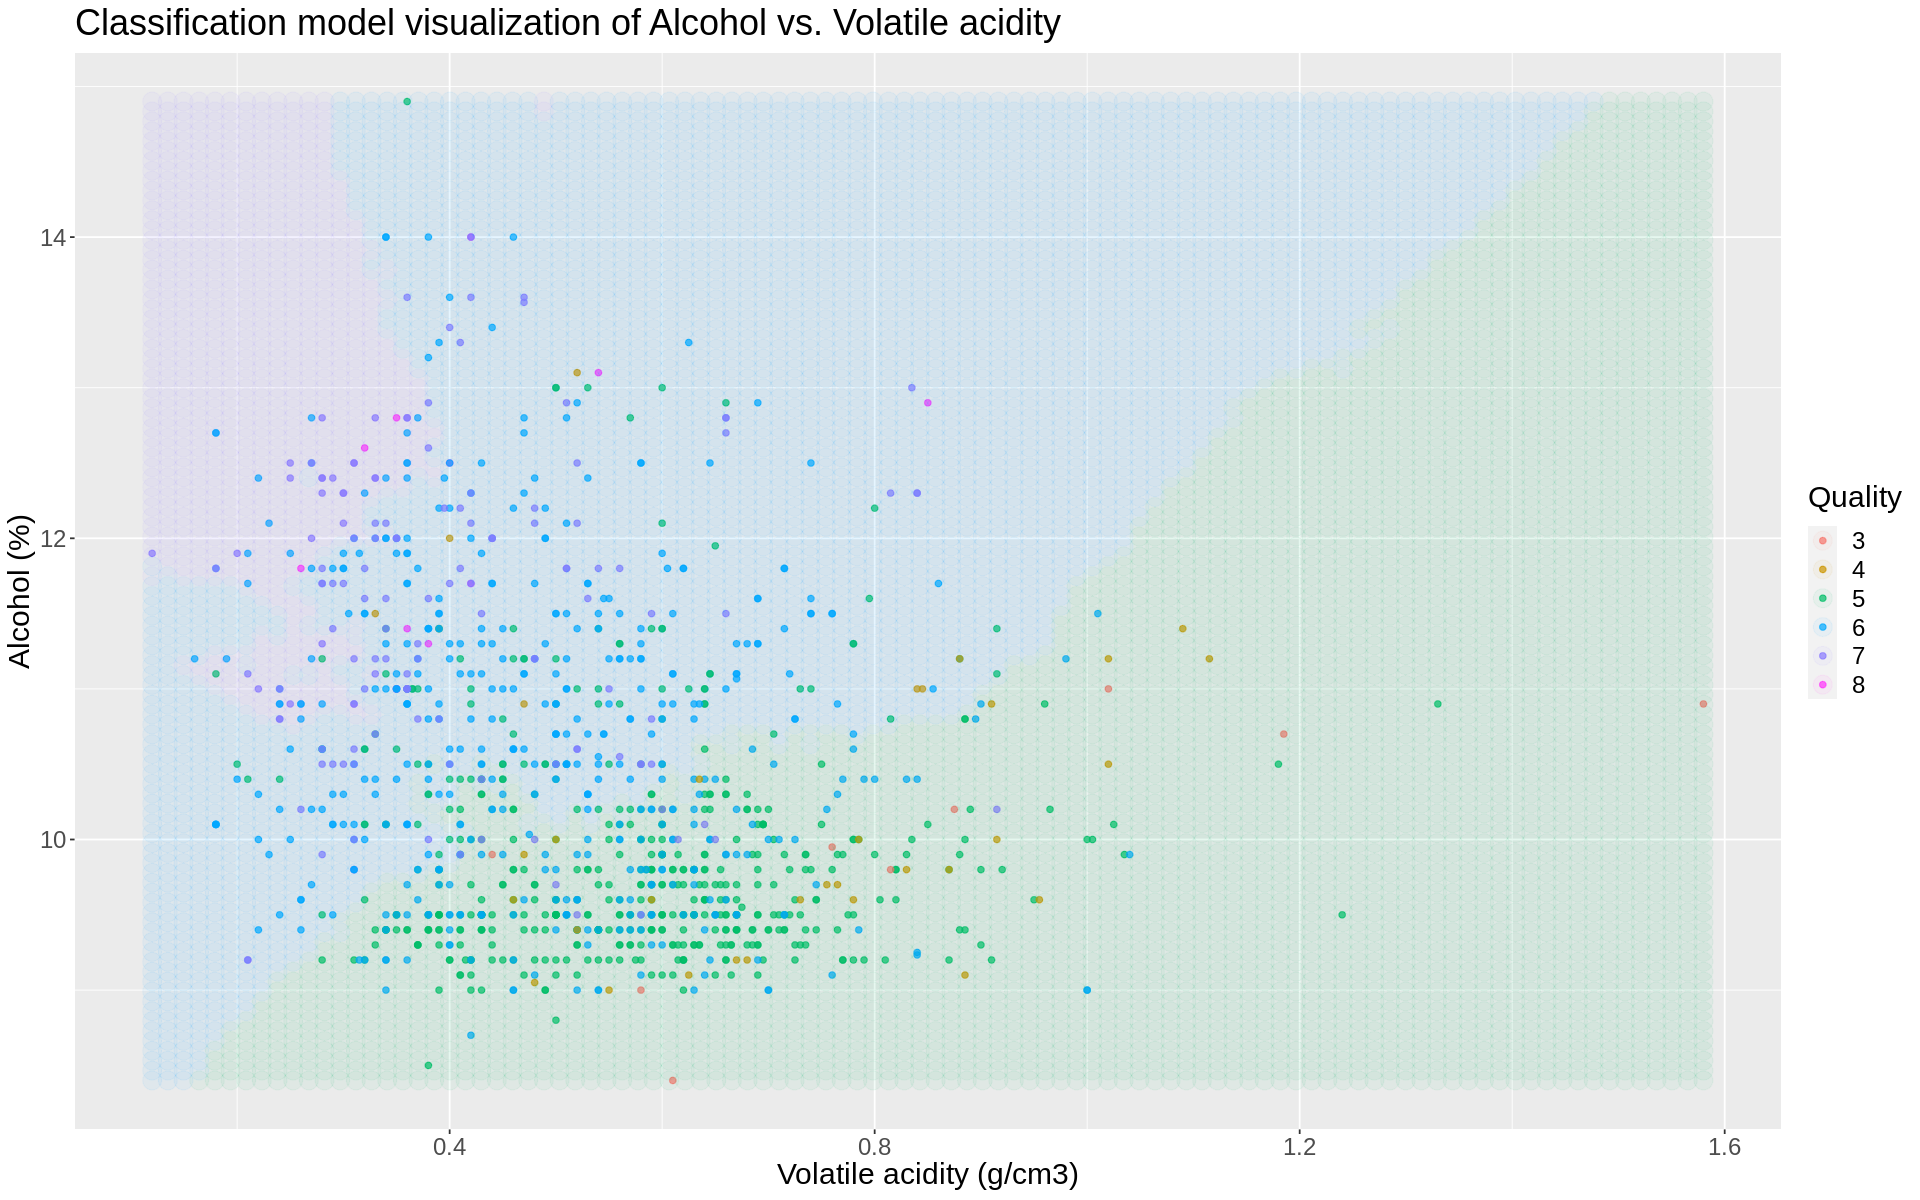

In [28]:
options(repr.plot.width = 16, repr.plot.height = 10)

# create visualization with background color
classification_plot <- ggplot() +
    geom_point(red_training_data, mapping = aes(x = volatile_acidity, y = alcohol, color = quality), alpha = 0.7) +
    geom_point(pred_table, mapping = aes(x = volatile_acidity, y = alcohol, color = quality), alpha = 0.05, size = 5) +
    ggtitle("Classification model visualization of Alcohol vs. Volatile acidity") +
    labs(x = "Volatile acidity (g/cm3)", y = "Alcohol (%)", color = "Quality") + 
    theme(text = element_text(size = 18)) +
    scale_color_manual(values = COLOR_PALETTE)
classification_plot

## Discussion

Since volatile acidity and alcohol had the strongest relative correlations with quality, we have determined they were appropriate and chose those predictors to predict the quality of red wine. As seen in the classification model visualization, the majority of quality ratings are either 5, 6, or 7. It appears that as `volatile acidity` increases, `quality` decreases, indicating a moderate, negative relationship between volatile acidity levels and quality rating. On the other hand, as `alcohol` increases, `quality` increases as well, but to a varying degree. This indicates a weak, positive relationship between alcohol content and quality rating. The estimated prediction accuracy of our model was approximately 0.5385 (53.85%), indicating that this model isn't entirely accurate.

We decided to use the K-NN (K nearest neighbour) classification model with cross-validation. This was an suitable model to use, because it effectively determined the most accurate K value and maintained appropriate fit.

# \<remember to change accuracy when final model is trained with proper k>

We assumed that a moderate balance of alcohol features will lead to the highest quality rating and that alcohol with extremely strong or weak features will subsequently lead to a lower quality rating. We did not expect to find a somewhat positive relationship between alcohol and quality. We also did not expect to find that volatile acidity had a relatively strong, negative correlation. Both these relationships contradicted our expectation that a moderate balance of each feature would provide the highest quality ratings.

It is worth noting that the model only predicts 5, 6, and 7 quality ratings. The model cannot  predict extreme quality ratings because of the somewhat higher k-value and the fairly small proportion of extreme quality ratings.

We did expect to find that the majority of quality ratings would fall in the center of quality ratings (5, 6, and 7), as extreme quality ratings (either very high or very low) are rare. We did expect a somewhat lower accuracy score (0.5385). This is because quality is an extremely subjective variable, and therefore, cannot be predicted with a high level of accuracy. Each person has different tastes which would affect their rating of red wine quality.

In terms of practical applications, the impacts of these findings could suggest that a higher alcohol percentage and a lower volatile acidity may lead to a higher quality rating of red wine. This could potentially allow winemakers to concoct a specific type of red wine they can assume will be successful without having to physically taste the wine. It is known that alcohol activates the brain's reward system, so it makes sense that a higher alcohol content leads to increased quality ratings. However, some types of red wine are known to be acidic, so other components of the wine must balance out the acidity. This may explain why as volatile acidity increases, quality ratings decrease. [(2)](#ref_2)

This also raises further questions of whether the negative relationship between volatile acidity and quality and the positive relationship between alcohol percentage and quality for red wine could potentially be applied to other types of alcohol (eg. white wine, beer, tequila, vodka). However, other types of alcohol may not share the same attributes, so the applicability is unknown.

### References: 
1. <a id='ref_1'></a>https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377

2. <a id='ref_2'></a>https://www.jjbuckley.com/wine-knowledge/blog/the-4-factors-and-4-indicators-of-wine-quality/1009

3. <a id='ref_3'></a>https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv